# Problema 2 

**Grupo 8**<br>
- Anabela Pereira - A87990
- André Gonçalves - A87942

In [ ]:
from z3 import *
import math as m
import matplotlib.pyplot as plt

Neste problema foi nos pedido para criar um autómato híbrido que modele 3 navios num lago infinito.
Então criámos o seguinte autómato:

<img src="automatop2.png" width="500"/>

Os navios foram denominados A, B e C.

O estado contínuo de cada navio N é formado por:
- xN: posição no eixo X;
- yN: posição no eixo Y;
- tN: tempo;
- rN: ângulo por unidades de 15º ($0 \leq rN \leq 24$);
- vN: velocidade ($vN = 1 \vee vN = 10$).

Dois navios, N1 e N2, colidem quando xN1 = xN2 e yN1 = yN2 e tN1 = tN2 por isso é necessário inicializar o estado com os navios em posições diferentes, além disto o tempo dos navios é igual a 0 e a velocidade é 10. Assim para iniciar o estado temos:
$$
m = \mathsf{INIT}\\
xA \neq xB \vee yA \neq yB\\
xA \neq xC \vee yA \neq YC \\
xB \neq xC \vee yB \neq yC\\
tA = tB = tC = 0\\
vA = vB = vC = 10
$$

Foram criadas as funções dist_col_ab, dist_col_ac e dist_col_bc para calcular se dois navios estão em distância de colisão, respetivamente, os navios A e B, A e C, B e C dadas duas constantes $r$ e $v$ nas equações $|xN1 - xN2| \leq r \vee |yN1 - yN2| \leq r \vee |tN1 - tN2| \leq r/v$. Usamos $r$ = 30 e $v$ = 5.

Foi criada uma função prox que calcula os proximos pontos dum estado.

Os navios mudam de velocidade instantaneamente.

Os seguintes predicados explicitam colisões entre dois navios:
- $ab(s)$ : predicado que diz se os navios A e B estão em colisão dado o estado
- $ac(s)$ : predicado que diz se os navios A e C estão em colisão dado o estado
- $bc(s)$ : predicado que diz se os navios B e C estão em colisão dado o estado

Temos as seguites transições:
- INIT para NORMAL
$$
m = \mathsf{INIT} \wedge m' = \mathsf{NORMAL}\\
\forall\ navio\ N , \quad xN' = xN \wedge yN' = yN \wedge tN' = tN \wedge vN' = vN \wedge rN' = rN
$$

- NORMAL para NORMAL: quando nenhum navio está numa distância de colisão com outro
$$
m = \mathsf{NORMAL} \wedge m' = \mathsf{NORMAL}\\
xA \neq xB \vee yA \neq yB \vee tA \neq tB\\
xA \neq xC \vee yA \neq yC \vee tA \neq tC \\
xB \neq xC \vee yB \neq yC \vee tB \neq tC\\
\neg ab \wedge \neg ac \wedge \neg bc\\  
\forall\ navio\ N , \quad (xN',yN') = prox \wedge tN' > tN \wedge vN' = vN \wedge rN' = rN
$$

- NORMAL para COLISAO: quando dois navios estão em distância de colisão<br>
$\alpha$ : N está em colisão com outro navio
$$
m = \mathsf{NORMAL} \wedge m' = \mathsf{COLISAO}\\
ab \vee ac \vee bc\\
\forall\ navio\ N , \quad (xN',yN') = (xN ,yN) \wedge tN' = tN \wedge (\alpha \implies (rN' = (rN + 1) \% 24 \vee rN' = (rN - 1) \% 24) \wedge vN' = 1) \wedge (\neg \alpha \implies rN' = rN \wedge vN' = 10)
$$
- COLISAO para COLISAO: enquanto dois navios estão em distância de colisão
$$
m = \mathsf{COLISAO} \wedge m' = \mathsf{COLISAO}\\
ab \vee ac \vee bc\\
\forall\ navio\ N , \quad (xN',yN') = prox \wedge tN' > tN \wedge vN' = vN \wedge rN' = rN
$$
- COLISAO para NORMAL: quando dois navios já não estão em distância de colisão
$$
m = \mathsf{COLISAO} \wedge m' = \mathsf{NORMAL}\\
\neg ab \wedge \neg ac \wedge \neg bc\\  
\forall\ navio\ N , \quad (xN',yN') = (xN, yN) \wedge tN' = tN \wedge vN' = 10 \wedge rN' = rN
$$

In [84]:
V = ['xa','ya','ta','ra','va',
     'xb','yb','tb','rb','vb',
     'xc','yc','tc','rc','vc']

def ab (x,z,r):
    return And(x<=z+r,z<=x+r)

def dist(P0,P1,r,v):

    return And(ab(P0[0],P1[0],r),
               ab(P0[1],P1[1],r),
               ab(P0[2],P1[2],r/v))

def dist_col_ab(s,r,v):
    return dist((s['xa'],s['ya'],s['ta']),(s['xb'],s['yb'],s['tb']),r,v)

def dist_col_ac(s,r,v):
    return dist((s['xa'],s['ya'],s['ta']),(s['xc'],s['yc'],s['tc']),r,v)

def dist_col_bc(s,r,v):
    return dist((s['xb'],s['yb'],s['tb']),(s['xc'],s['yc'],s['tc']),r,v)


def prox_x(x,y,v,t,r):
    d = v*t
    a = m.cos(r*(m.pi/12))*d
    return x+a  

def prox_y(x,y,v,t,r):
    d = v*t
    o = m.sin(r*(m.pi/12))*d
    return y+o
    
def prox_r(s,p):
    con = []
    for i in range(24):
        con.append(Implies(s['ra']==i,
            And(p['xa'] == prox_x(s['xa'],s['ya'],s['va'],p['ta']-s['ta'],i),p['ya'] == prox_y(s['xa'],s['ya'],s['va'],p['ta']-s['ta'],i))))
        con.append(Implies(s['rb']==i,
            And(p['xb'] == prox_x(s['xb'],s['yb'],s['vb'],p['tb']-s['tb'],i),p['yb'] == prox_y(s['xb'],s['yb'],s['vb'],p['tb']-s['tb'],i))))
        con.append(Implies(s['rc']==i,
            And(p['xc'] == prox_x(s['xc'],s['yc'],s['vc'],p['tc']-s['tc'],i),p['yc'] == prox_y(s['xc'],s['yc'],s['vc'],p['tc']-s['tc'],i))))
        
    return And(con)
        
Modo, (Init,Normal,Colisao) = EnumSort('Modo', ('INIT','NORMAL','COLISAO'))

def declare(i,solver):
    s = {}
    
    s['m'] = Const('m'+str(i),Modo)
    k = 0
    con = []
    while k<len(V):
        if (k+1)%5==4:
            s[V[k]] = Int(V[k]+str(i))
            solver.add(And(s[V[k]]<24,s[V[k]]>=0))
        elif (k+1)%5==0:
            s[V[k]] = Int(V[k]+str(i))
            solver.add(Or(s[V[k]]==1,s[V[k]]==10))
        else:
            s[V[k]] = Real(V[k]+str(i))
        k+=1

    return s

def init(s):
    return And(s['m']==Init, 
               Or(s['xa']!=s['xb'],s['ya']!=s['yb']),
               Or(s['xa']!=s['xc'],s['ya']!=s['yc']),
               Or(s['xb']!=s['xc'],s['yb']!=s['yc']),
               s['ta']==0, s['tb']==0, s['tc']==0,
               And([s[V[k]]==10 for k in range(4,len(V),5)]))


r = 30
v = 5
def trans(s,p):
    
    col_ab = dist_col_ab(s,r,v)
    col_ac = dist_col_ac(s,r,v)
    col_bc = dist_col_bc(s,r,v)
    #U
    tIN = And( s['m']==Init,p['m']==Normal,
               And([p[z]==s[z] for z in V]))
    #T
    tNN = And(s['m']==Normal, p['m']==s['m'],
               Not(col_ab),
               Not(col_ac),
               Not(col_bc),
               Or(s['xa']!=s['xb'],s['ya']!=s['yb'],s['ta']!=s['tb']),
               Or(s['xa']!=s['xc'],s['ya']!=s['yc'],s['ta']!=s['tc']),
               Or(s['xb']!=s['xc'],s['yb']!=s['yc'],s['tb']!=s['tc']),
               prox_r(s,p),
               p['ta']>s['ta'], p['tb']>s['tb'], p['tc']>s['tc'],
               And([And(p[V[j]]==s[V[j]],p[V[j+1]]==s[V[j+1]]) for j in range(3,len(V),5)]))
    #U
    tNC = And(s['m']==Normal, p['m']==Colisao,
               Or(col_ab,col_ac,col_bc),
               Implies(col_ab,And(p['va']==1,p['vb']==1,
                      Or(p['ra']==(s['ra']+1)%24,p['ra']==(s['ra']-1)%24),
                      Or(p['rb']==(s['rb']+1)%24,p['rb']==(s['rb']-1)%24))),
               Implies(col_ac,And(p['va']==1,p['vc']==1,
                      Or(p['ra']==(s['ra']+1)%24,p['ra']==(s['ra']-1)%24),
                      Or(p['rc']==(s['rc']+1)%24,p['rc']==(s['rc']-1)%24))),
               Implies(col_bc,And(p['va']==1,p['vb']==1,
                      Or(p['rc']==(s['rc']+1)%24,p['rc']==(s['rc']-1)%24),
                      Or(p['rb']==(s['rb']+1)%24,p['rb']==(s['rb']-1)%24))),
               Implies(Not(Or(col_ab,col_ac)),And(p['ra']==s['ra'],p['va']==s['va'])),
               Implies(Not(Or(col_ab,col_bc)),And(p['rb']==s['rb'],p['vb']==s['vb'])),
               Implies(Not(Or(col_bc,col_ac)),And(p['rc']==s['rc'],p['vc']==s['vc'])),
               And([p[V[j]]==s[V[j]] for j in range(len(V)) if (j+1)%5 in [1,2,3]]))
               
    #T
    tCC = And(s['m']==Colisao, p['m']==s['m'],
               Or(col_ab,col_ac,col_bc),
               And([p[V[j]]==s[V[j]] for j in range(len(V)) if (j+1)%5 in [0,4]]),
               prox_r(s,p),
               p['ta']>s['ta'], p['tb']>s['tb'], p['tc']>s['tc'])
    
    #U
    tCN = And(s['m']==Colisao, p['m']==Normal,
               Not(col_ab),
               Not(col_ac),
               Not(col_bc),
               p['va']==10,p['vb']==10,p['vc']==10,
               And([p[V[j]]==s[V[j]] for j in range(len(V)) if (j+1)%5!=0]))
    
    return Or(tIN,tNN,tNC,tCC,tCN)


-> 0
m = INIT
xa = 0.0
ya = -31.25
ta = 0.0
ra = 11
va = 10
xb = 263.88047595349656
yb = -62.129409522551256
tb = 0.0
rb = 11
vb = 10
xc = 0.5
yc = -31.083333333333332
tc = 0.0
rc = 1
vc = 10


-> 1
m = NORMAL
xa = 0.0
ya = -31.25
ta = 0.0
ra = 11
va = 10
xb = 263.88047595349656
yb = -62.129409522551256
tb = 0.0
rb = 11
vb = 10
xc = 0.5
yc = -31.083333333333332
tc = 0.0
rc = 1
vc = 10


-> 2
m = COLISAO
xa = 0.0
ya = -31.25
ta = 0.0
ra = 12
va = 1
xb = 263.88047595349656
yb = -62.129409522551256
tb = 0.0
rb = 11
vb = 10
xc = 0.5
yc = -31.083333333333332
tc = 0.0
rc = 2
vc = 1


-> 3
m = COLISAO
xa = -5.04227015029907e+17
ya = 30.5
ta = 5.04227015029907e+17
ra = 12
va = 1
xb = 32.01036297108185
yb = 0.0
tb = 24.00496049196887
rb = 11
vb = 10
xc = 1.5103629710818454
yc = -30.5
tc = 1.166666666666667
rc = 2
vc = 1


-> 4
m = NORMAL
xa = -5.04227015029907e+17
ya = 30.5
ta = 5.04227015029907e+17
ra = 12
va = 10
xb = 32.01036297108185
yb = 0.0
tb = 24.00496049196887
rb = 11
vb = 10
xc = 1.51

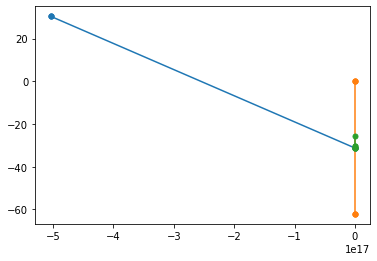

In [85]:
def ad(XA,YA,XB,YB,XC,YC,w,k):
    if k==1:
        XA.append(w)
    elif k==2:
        YA.append(w)
    elif k==6:
        XB.append(w)
    elif k==7:
        YB.append(w)
    elif k==11:
        XC.append(w)
    elif k==12:
        YC.append(w)
            
def gera_traco(declare,init,trans,k):
    XA = []
    YA = []
    XB = []
    YB = []
    XC = []
    YC = []
    
    s = Solver()
    state = [declare(i,s) for i in range(k)]
    s.add(init(state[0]))
    s.add(state[3]['m']==Colisao)
    for i in range(k-1):
        s.add(trans(state[i],state[i+1]))
    
    if s.check() == sat:
        m = s.model()
        for i in range(k):
            print('->',i)
            k=0
            for x in state[i]:
                if state[i][x].sort() != RealSort():
                    print(x,'=',m[state[i][x]])
                    ad(XA,YA,XB,YB,XC,YC,m[state[i][x]],k)
                else:
                    print(x,'=',float(m[state[i][x]].numerator_as_long())/float(m[state[i][x]].denominator_as_long()))
                    ad(XA,YA,XB,YB,XC,YC,float(m[state[i][x]].numerator_as_long())/float(m[state[i][x]].denominator_as_long()),k)
                
                k+=1
            print('\n')
        
        plt.plot(XA,YA,label="A",marker='o',markersize=5)
        plt.plot(XB,YB,label="B",marker='o',markersize=5)
        plt.plot(XC,YC,label="C",marker='o',markersize=5)
            
    else:
        print('fail')
               
gera_traco(declare,init,trans,6)

Para testar se navios colidem, ou seja, para dois navios N1 e N2 $xN1 = xN2 \wedge yN1 = yN2 \wedge tN1 = tN2$ temos a seguinte propriedade:

In [86]:
def naocolidem (s):
    return Not(Or(And(s['xa']==s['xb'],s['ya']==s['yb'],s['ta']==s['tb']),
             And(s['xa']==s['xc'],s['ya']==s['yc'],s['ta']==s['tc']),
             And(s['xc']==s['xb'],s['yc']==s['yb'],s['tc']==s['tb'])))

Usando bmc concluímos que dois navios podem colidir porque dois navios ao entrar numa distância de colisão podem escolher uma direção (estibordo ou bombordo) e invés de evitar colisão podem provocar uma colisão.

0
m = INIT
xa = 834.1060782499637
ya = 232.17050043811759
ta = 0.0
ra = 2
va = 10
xb = 895.1060782499638
yb = 0.0
tb = 0.0
rb = 12
vb = 10
xc = 864.6060782499638
yc = 231.67050043811759
tc = 0.0
rc = 13
vc = 10


1
m = NORMAL
xa = 834.1060782499637
ya = 232.17050043811759
ta = 0.0
ra = 2
va = 10
xb = 895.1060782499638
yb = 0.0
tb = 0.0
rb = 12
vb = 10
xc = 864.6060782499638
yc = 231.67050043811759
tc = 0.0
rc = 13
vc = 10


2
m = NORMAL
xa = 838.4362052688859
ya = 234.67050043811759
ta = 0.5
ra = 2
va = 10
xb = 0.0
yb = 1.0961887936261584e-13
tb = 89.51060782499638
rb = 12
vb = 10
xc = 0.0
yc = 1.0961887936261584e-13
tc = 89.51060782499638
rc = 13
vc = 10




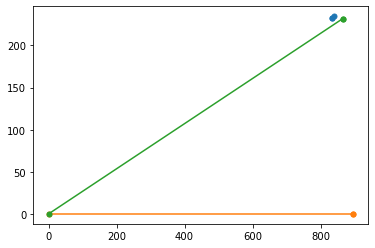

In [87]:
def bmc_always(declare,init,trans,inv,K):
    XA = []
    YA = []
    XB = []
    YB = []
    XC = []
    YC = []
    for k in range(1,K+1):
        s = Solver()
        state = [declare(i,s) for i in range(k)]
        s.add(init(state[0]))
    
        for i in range(k-1):
            s.add(trans(state[i],state[i+1]))
    
        s.add(Not(inv(state[k-1])))
        
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                print(i)
                k=0
                for x in state[i]:
                    if state[i][x].sort() != RealSort():
                        print(x,'=',m[state[i][x]])
                        ad(XA,YA,XB,YB,XC,YC,m[state[i][x]],k)
                    else:
                        print(x,'=',float(m[state[i][x]].numerator_as_long())/float(m[state[i][x]].denominator_as_long()))
                        ad(XA,YA,XB,YB,XC,YC,float(m[state[i][x]].numerator_as_long())/float(m[state[i][x]].denominator_as_long()),k)
                    k+=1
                print('\n')
            plt.plot(XA,YA,label="A",marker='o',markersize=5)
            plt.plot(XB,YB,label="B",marker='o',markersize=5)
            plt.plot(XC,YC,label="C",marker='o',markersize=5)
           
            return
        
     
        
    print ("Property is valid up to traces of length "+str(K))

bmc_always(declare,init,trans,naocolidem,10)